In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pdb;
import time
import copy

In [3]:
wheel_radius = 0.025
wheel_sep = 0.09
tail_dist = 0.075
robot_height = tail_dist  + wheel_radius

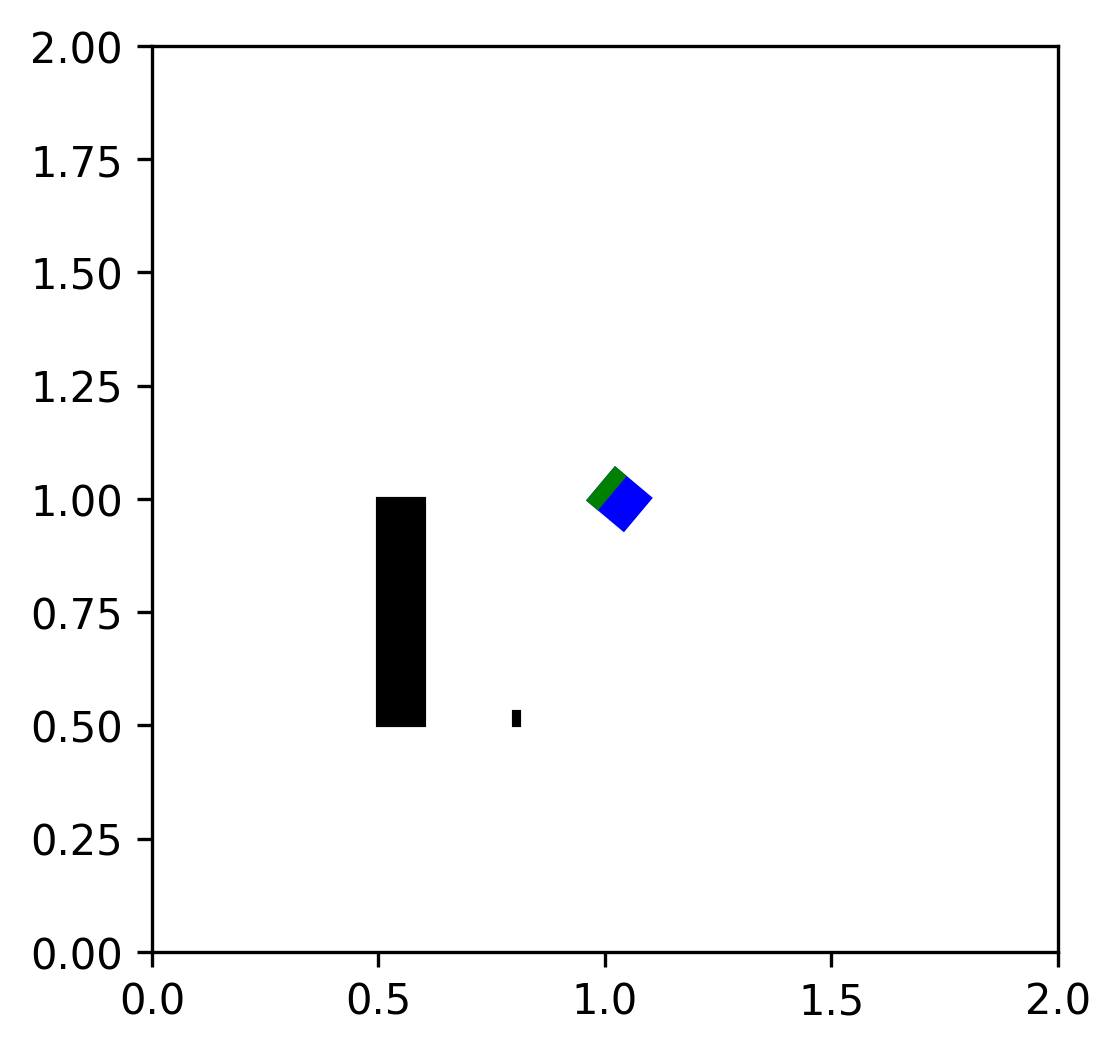

In [4]:
def show_world(obstacles = [[[0.5,0.5],[0.1,0.5]], [[0.8,0.5],[0.01,0.03]]],oneway = None, target = None,dimensions = [2,2]):
    plt.rcParams['figure.dpi'] = 300
    fig = plt.figure()
    ax=fig.add_subplot(111)
    plt.plot()
    
    for obstacle in obstacles:
        ax.add_patch(patches.Rectangle((obstacle[0][0],obstacle[0][1]),obstacle[1][0],obstacle[1][1],color='k'))

    if oneway is not None:
        for ow in oneway:
            ax.add_patch(patches.Rectangle((ow[0][0],ow[0][1]),ow[1][0],ow[1][1],color='y'))
    if target is not None:
        
        ax.add_patch(patches.Rectangle((target[0][0],target[0][1]),target[1][0],target[1][1],color='g'))

    plt.axis([0,dimensions[0],0,dimensions[1]])
#         plt.axis('equal')
    plt.gca().set_aspect('equal', adjustable='box')
    return ax
        
#         plt.grid()

def plot_robot(rc,ax):       
    coords = [0.025,0.075]
    robot_dims = [0.05,0.1]
    tr = matplotlib.transforms.Affine2D().rotate_deg_around(rc[0],rc[1], 50) + ax.transData
    ax.add_patch(patches.Rectangle((rc[0]-coords[0],rc[1]-coords[1]),wheel_sep,robot_height,color='b',transform = tr))
    ax.add_patch(patches.Rectangle((rc[0]-coords[0],rc[1]),wheel_sep,wheel_radius,color='g',transform = tr))
            
  
ax = show_world()
plot_robot([1,1,np.pi/2],ax)



In [5]:
def get_angle_diff(a1,a2):
    ang_cw =  (a2 -a1)% (2*np.pi)
    ang_ccw = (- a2 + a1)% (2*np.pi)
    
    ang = np.minimum(ang_cw,ang_ccw) 
    if ang == ang_ccw:
        ang = - ang
    return ang

def get_dist_diff(c1,c2):
    dist = np.sqrt(((c1[0] - c2[0])**2 + (c1[1] - c2[1])**2))
    return dist



In [6]:
w_wheel_rpm = 60
w_wheel = w_wheel_rpm * 2 * np.pi /60
v_wheel = w_wheel * wheel_radius

w_robot = v_wheel / (wheel_sep/2)
v_robot = v_wheel

print(v_robot,w_robot)



0.15707963267948966 3.490658503988659


In [7]:
def plan_trajectory(xi,xt):
    ang_points =  np.arctan2(xt[1] - xi[1], xt[0] - xi[0])
    ang1 = get_angle_diff(xi[2],ang_points) 

    dist = get_dist_diff(xi,xt)
    print(xi,xt,dist)
    
    ang2 =  get_angle_diff(ang_points,xt[2])
    
    return [ang1,dist,ang2]
     
print(plan_trajectory([1,1,0],[1,2,0]))        
print(plan_trajectory([1,1,0],[1,0,-np.pi]))  
print(plan_trajectory([1,1,0],[2,2,-np.pi]))  

[1, 1, 0] [1, 2, 0] 1.0
[1.5707963267948966, 1.0, -1.5707963267948966]
[1, 1, 0] [1, 0, -3.141592653589793] 1.0
[-1.5707963267948966, 1.0, -1.5707963267948966]
[1, 1, 0] [2, 2, -3.141592653589793] 1.4142135623730951
[0.7853981633974483, 1.4142135623730951, 2.356194490192345]


In [8]:
def time_trajectory(xi,xt):
    ang_points = np.arctan2(xt[1] - xi[1], xt[0] - xi[0])
    ang1 = get_angle_diff(xi[2],ang_points) 
    t = np.abs(ang1/w_robot)

    dist = get_dist_diff(xi,xt)
    t += np.abs(dist/v_robot)
    
    ang2 =  get_angle_diff(ang_points,xt[2])
    t += np.abs(ang2/w_robot)
    return [[ang1,dist,ang2],t]
     
print(time_trajectory([1,1,np.pi/2],[1,2,np.pi]))        
print(time_trajectory([1,1,0],[1,0,-np.pi]))  
print(time_trajectory([1,1,0],[2,2,-np.pi]))  

[[-0.0, 1.0, 1.5707963267948966], 6.816197723675814]
[[-1.5707963267948966, 1.0, -1.5707963267948966], 7.266197723675814]
[[0.7853981633974483, 1.4142135623730951, 2.356194490192345], 9.903163161571062]


In [9]:
def metric(c1,c2):
#     dist = get_dist_diff(c1,c2)
#     ang = get_angle_diff(c1[2],c2[2])
    
#     rot_dist =  np.abs(ang) * wheel_sep
    
#     metric = dist + rot_dist
    
    return time_trajectory(c1,c2)[-1]

print(metric([1,1,0],[2,1,0]))

print(metric([1,1,0],[1,1,np.pi/4]))
print(metric([1,1,0],[1,1,-np.pi/4]))

6.366197723675814
0.225
0.225


In [10]:
def execute_trajectory(xi,xt,duration = 1):
    t = 0
    ang1 = 0
    dist = 0
    ang2 = 0
    control_seq = [[0,0,0]]
    x_end = copy.deepcopy(xi)
    
    ang_points =  np.arctan2(xt[1] - xi[1], xt[0] - xi[0])
    ang1 = get_angle_diff(xi[2],ang_points) 
    if ang1!=0:
        t_ang1 = np.abs(ang1/w_robot)
        t = t_ang1

        control_seq[-1][0] = np.sign(ang1) * w_wheel_rpm
        control_seq[-1][1] = -np.sign(ang1)*w_wheel_rpm
        if t_ang1>duration:
            ang1 = w_robot*duration*np.sign(ang1)
            control_seq[-1][2] = duration
            t = duration
            x_end[2] = xi[2] + ang1
            return [[ang1,dist,ang2],control_seq,x_end]
        else:
            control_seq[-1][2] = t_ang1
            t = t_ang1
            x_end[2] = xi[2] + ang1
            control_seq.append([0,0,0])
    
    dist = get_dist_diff(xi,xt)
    if dist!=0:
        t_dist = dist/v_robot

        control_seq[-1][0] = w_wheel_rpm
        control_seq[-1][1] = w_wheel_rpm
        if  t + t_dist>duration:
            dist = v_robot* (duration - t)
            x_end[0] += dist*np.cos(x_end[2])
            x_end[1] += dist*np.sin(x_end[2])
            t_dist = duration - t
            control_seq[-1][2] = t_dist
            return [[ang1,dist,ang2],control_seq,x_end]
        else:
            control_seq[-1][2] = t_dist
            t = t + t_dist
            x_end[0] += dist*np.cos(x_end[2])
            x_end[1] += dist*np.sin(x_end[2])
            control_seq.append([0,0,0])
    
    ang2 =  get_angle_diff(ang_points,xt[2])
    if ang2!=0:
        t_ang2 =  np.abs(ang1/w_robot)
        control_seq[-1][0] = np.sign(ang1) * w_wheel_rpm
        control_seq[-1][1] = -np.sign(ang1)*w_wheel_rpm
        if t + t_ang1>duration:
            ang2 = w_robot*np.sign(ang2)
            control_seq[-1][2] = duration - t
            x_end[2] = x_end[2] + ang2
            t = duration
            return [[ang1,dist,ang2],control_seq,x_end]
        else:
            control_seq[-1][2] = t_ang2
            t = t + t_ang1
            x_end[2] = x_end[2] + ang2
            control_seq.append([0,0,0])
            control_seq[-1][2] = duration - t

        
    return [[ang1,dist,ang2],control_seq,x_end]


print(time_trajectory([1,1,0],[1,1.1,0]))    
print(execute_trajectory([1,1,0],[1,1.1,0]))  

print()
print(time_trajectory([1,1,0],[1,0,-np.pi]))  
print(execute_trajectory([1,1,0],[1,0,-np.pi]))  

print()
print(time_trajectory([1,1,0],[2,2,-np.pi]))  
print(execute_trajectory([1,1,0],[2,2,-np.pi])) 


print()
print(time_trajectory([0,0,np.pi/2],[-10,10,-np.pi]))  
print(execute_trajectory([0,0,0],[-10,10,-np.pi])) 

#  s [1.0074272458687608, 0.33980059164984955, 1.4882759426619756] traj [0.769366278000079, 0.12245815016948611, 0] end [1.0953952639734506, 0.4249922950819641, 2.2576422206620546]
print()
print(execute_trajectory([1.0074272458687608, 0.33980059164984955, 1.4882759426619756],[0.23654885173786644, 1.2798420426550476, 0.9007152691844127])) 


[[1.5707963267948966, 0.10000000000000009, -1.5707963267948966], 1.5366197723675818]
[[1.5707963267948966, 0.08639379797371932, 0], [[60.0, -60.0, 0.45], [60, 60, 0.55]], [1.0, 1.0863937979737193, 1.5707963267948966]]

[[-1.5707963267948966, 1.0, -1.5707963267948966], 7.266197723675814]
[[-1.5707963267948966, 0.08639379797371932, 0], [[-60.0, 60.0, 0.45], [60, 60, 0.55]], [1.0, 0.9136062020262807, -1.5707963267948966]]

[[0.7853981633974483, 1.4142135623730951, 2.356194490192345], 9.903163161571062]
[[0.7853981633974483, 0.12173671532660449, 0], [[60.0, -60.0, 0.225], [60, 60, 0.775]], [1.0860808569268183, 1.0860808569268183, 0.7853981633974483]]

[[0.7853981633974483, 14.142135623730951, 0.7853981633974483], 90.4816316157106]
[[2.356194490192345, 0.051050880620834134, 0], [[60.0, -60.0, 0.675], [60, 60, 0.32499999999999996]], [-0.03609842387253672, 0.03609842387253672, 2.356194490192345]]

[[0.769366278000079, 0.12245815016948611, 0], [[60.0, -60.0, 0.2204072031454666], [60, 60, 0.779

In [11]:
# https://math.stackexchange.com/questions/261336/intersection-between-a-rectangle-and-a-circle

furthest_point_robot = np.sqrt((wheel_sep/2)**2+tail_dist**2)

def intersect_circle_segment(c,r,seg,vert):
    intersect = False
    xc,yc = c
    circ = lambda x,y: (x - xc)**2+(y-yc)**2 - r**2
    if vert:
        x = seg[0][0]
        y1 = seg[0][1]
        y2 = seg[1][1]
        if yc<y2 and yc>y1: 
            if np.abs(x-xc)<=r:
                intersect = True
        else:
            if circ(x,y1)<0 or circ(x,y2)<0:
                intersect = True
    else:
        y = seg[0][1]
        x1 = seg[0][0]
        x2 = seg[1][0]
        if xc<x2 and xc>x1: 
            if np.abs(y-yc)<=r:
                intersect = True
        else:
            if circ(x1,y)<0 or circ(x2,y)<0:
                intersect = True
    return intersect

def interset_circle_obstacle(c,r,obstacle):
    oc = obstacle[0]
    od = obstacle[1]
    rec_corn = [ [oc[0],oc[1]],[oc[0]+od[0],oc[1]],[oc[0]+od[0],oc[1]+od[1]],[oc[0],oc[1]+od[1]]]
#     import pdb; pdb.set_trace()
    intersect = False
    if c[0] > oc[0] and c[0] <= oc[0]+od[0] and c[1] > oc[0] and c[1]<=oc[1]+od[1]:
        intersect = True
    intersect = intersect or (intersect_circle_segment(c,r,[rec_corn[0],rec_corn[1]],False) or intersect_circle_segment(c,r,[rec_corn[1],rec_corn[2]],True)
        or intersect_circle_segment(c,r,[rec_corn[2],rec_corn[3]],False) or intersect_circle_segment(c,r,[rec_corn[0],rec_corn[3]],True))
    
    return intersect
    
interset_circle_obstacle([0,0],1,[[-2,-2],[5,5]])

True

In [12]:
def intersect_line_obstacle(xi,dist,theta,obstacle):
#     theta = np.pi/2-theta
    intersect = False
    [[x1,y1],[tx,ty]] = obstacle
    x2 = x1+tx
    y2 = y1+ty
    get_dist_x = lambda x : (x - xi[0])/ np.cos(theta) 
    get_dist_y = lambda x : (x - xi[1])/ np.sin(theta)
    
    get_line_x = lambda d : xi[0] + d * np.cos(theta) 
    get_line_y = lambda d : xi[1] + d * np.sin(theta) 
    
    d_all = []
    
#     import pdb; pdb.set_trace()
    d = get_dist_x(x1)
    if d>0 and d<dist:
        y = get_line_y(d)
        if y>= y1 and y<y2:
            intersect = True
            d_all.append(d)
    d = get_dist_x(x2)
    if d>0 and d<dist:  
        y = get_line_y(d)
        if y>= y1 and y<y2:
            intersect = True
            d_all.append(d)

    d = get_dist_y(y1)
    if d>0 and d<dist:
        x = get_line_x(d)
        if x>= x1 and x<x2:
            intersect = True
            d_all.append(d)
    d = get_dist_y(y2)
    if d>0 and d<dist:
        x = get_line_x(d)
        if x>= x1 and x<x2:
            intersect = True
            d_all.append(d)
    
    if intersect:
        d = np.min(d_all)
        

    return [intersect,d]
        
    
# print(intersect_line_obstacle([0,0],10,np.pi/2,[[-1,1],[5,5]]))
# print(intersect_line_obstacle([0,0],10,0,[[1,-1],[5,5]]))
# print(intersect_line_obstacle([-0.5,0],10,np.pi/2,[[-1,1],[1,1]]))
# print(intersect_line_obstacle([0,0],10,0,[[-1,-2],[2,1]]))

# print(xi,traj[1]+furthest_point_robot)
# intersect_line_obstacle(xi,traj[1]+ furthest_point_robot,traj[0],obstacles_list[0])

In [13]:
def check_path_for_collision_old(xi,path,obstacle):
    ang1,dist,ang2 = path
    
    x1 = [xi[0]+furthest_point_robot*np.sin(ang1), xi[1]+furthest_point_robot*np.cos(ang1)]
    x2 = [xi[0]-furthest_point_robot*np.sin(ang1), xi[1]-furthest_point_robot*np.cos(ang1)]
#     print(x1,x2)
    [collision1,d1] =  intersect_line_obstacle(x1,dist + furthest_point_robot,ang1,obstacle)
    [collision2,d2] =  intersect_line_obstacle(x2,dist + furthest_point_robot,ang1,obstacle)
    collision = collision1 or collision2
#     print(collision1,collision2)
    d_all = []
    if collision1:
        d_all.append(d1-furthest_point_robot)
    if collision2:
        d_all.append(d2-furthest_point_robot)
    max_d = -1
    if len(d_all)>0:
        max_d = np.min(d_all)
    
    return collision,max_d
#TODO it drives right into a corner
# check_path_for_collision ([0,0],[np.pi/2,10,0], [[-1,1],[1,1]])

In [14]:
def check_path_for_collision(xi,path,obstacle):
    ang1,dist,ang2 = path
    
    padded_obstacle = copy.deepcopy(obstacle)
    padded_obstacle[0][0] -= furthest_point_robot
    padded_obstacle[0][1] -= furthest_point_robot
    padded_obstacle[1][0] += 2*furthest_point_robot
    padded_obstacle[1][1] += 2*furthest_point_robot
    
#     print(x1,x2)
    [collision,d] =  intersect_line_obstacle(xi,dist ,xi[2]+ang1,padded_obstacle)


    
    return collision,d
#TODO it drives right into a corner
check_path_for_collision ([0,0,0],[np.pi/2,10,0], [[-1,1],[2,2]])

(True, 0.9125357215773204)

In [15]:
# xi=[0.29044650718618625, 0.8134124653073828, 0.4414837032879717]
# x_new=[0.4442578458945158, 0.8234742290622096, 0.06532319517138596]
# traj=[0.06532319517138596, 0.1541400888967773, 0]
# xr=[0.5939287392181722, 1.360055908243145, 5.915713127729529]



# # print(xi,xr)
# print(execute_trajectory(xi,xr))
# traj,_,xn = execute_trajectory(xi,xr)
# print("traj",traj)
# print("xn",xn)
# print(check_path_for_collision(xi,traj,obstacles_list[-1]))

# print("obs",xx1,xx3,xx2,xx4)
# intersect_line_obstacle(xi,traj[1],traj[0],obstacles_list[-1])

In [17]:
def check_path_for_collisions(xi,path,obstacles):
    collision = False
    d_all = []
    for obstacle in obstacles:
#         print(obstacle)
        c,d = check_path_for_collision(xi,path,obstacle)  
        collision = c or collision
        if c:
            d_all.append(d)
    d = -1
    if collision:
        d = np.min(d_all)
    return collision,d
check_path_for_collisions ([0,0,0],[np.pi/2,10,0], [ [[-1,1],[1,1]], [[-1,5],[1,1]] ])

(True, 0.9125357215773204)

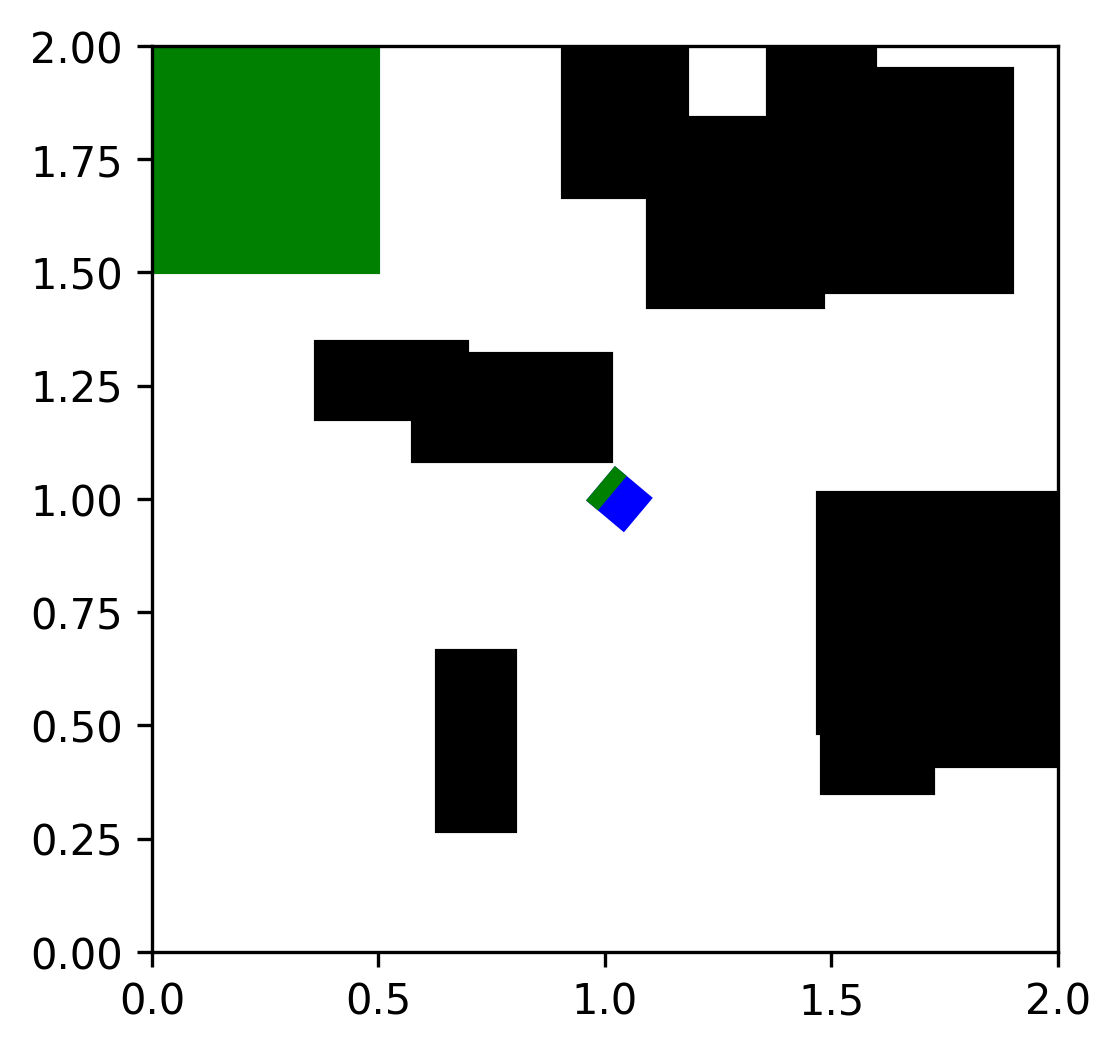

In [18]:
n_obstacles = 10
world_size = 2
np.random.seed(563121)
obstacle_positions = np.random.uniform(0.2,world_size-0.2,[n_obstacles,2]).tolist()
obstacle_dims = np.random.uniform(0.15,0.6,[n_obstacles,2]).tolist()

obstacles_list = []
for i in range(n_obstacles):
    obstacles_list.append([obstacle_positions[i],obstacle_dims[i]])

# obstacles_list= [[[0.5,0.5],[1,1]]]

target = [[0,1.5],[0.5,0.5]]
ax = show_world(obstacles_list,target = target,dimensions=[world_size,world_size])
plot_robot([1,1,np.pi/2],ax)

In [20]:
for ob in obstacles_list:
    print(ob)
    
xx1 = 0.344505291025931
xx2 = 0.6097855469027977
xx3 = xx1 + 0.571795719141825
xx4 = xx2 + 0.34382102230701117
    

[[1.467598037759669, 1.4566426868282212], [0.4313071273565947, 0.4915732219971404]]
[[1.0948020171642592, 1.4226013563764572], [0.38763172951846836, 0.41753145292176297]]
[[1.470889000892027, 0.48300822105128527], [0.5586456168631185, 0.5305320394271886]]
[[1.6172479279906429, 0.40946322182977735], [0.5717772761506767, 0.29194521488563774]]
[[1.4787656213253229, 0.3514645017225673], [0.24486496589883017, 0.28028720791330475]]
[[0.3617751019064006, 1.1767005921401672], [0.3332262751353172, 0.1688494076137968]]
[[0.6289098369034326, 0.2672757076622208], [0.17314615038118594, 0.39671564728951736]]
[[0.5768303176425751, 1.0840048151706434], [0.43653713586305043, 0.2364170120165474]]
[[1.359377326737208, 1.6818871552068164], [0.23741288227809468, 0.48936746133882314]]
[[0.9066388182568195, 1.6658927890405222], [0.2746150267704594, 0.4251475221823374]]


In [21]:
def plot_rrt_evol(E):
    ax = show_world(obstacles_list,target=target)      
    for e in E:
        ae = np.array(e)
        plt.plot(ae[:,0],ae[:,1],'b',linewidth =0.1)
    

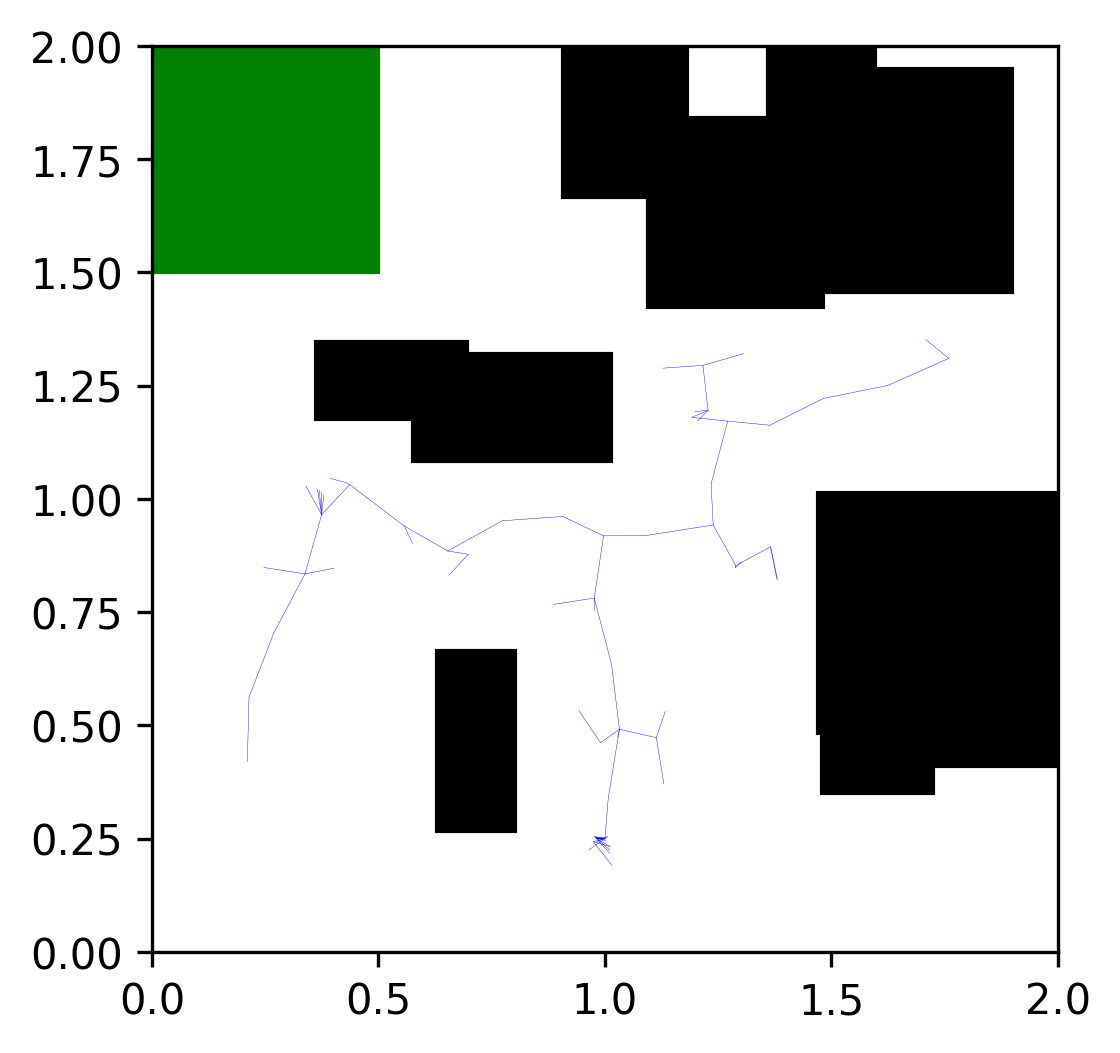

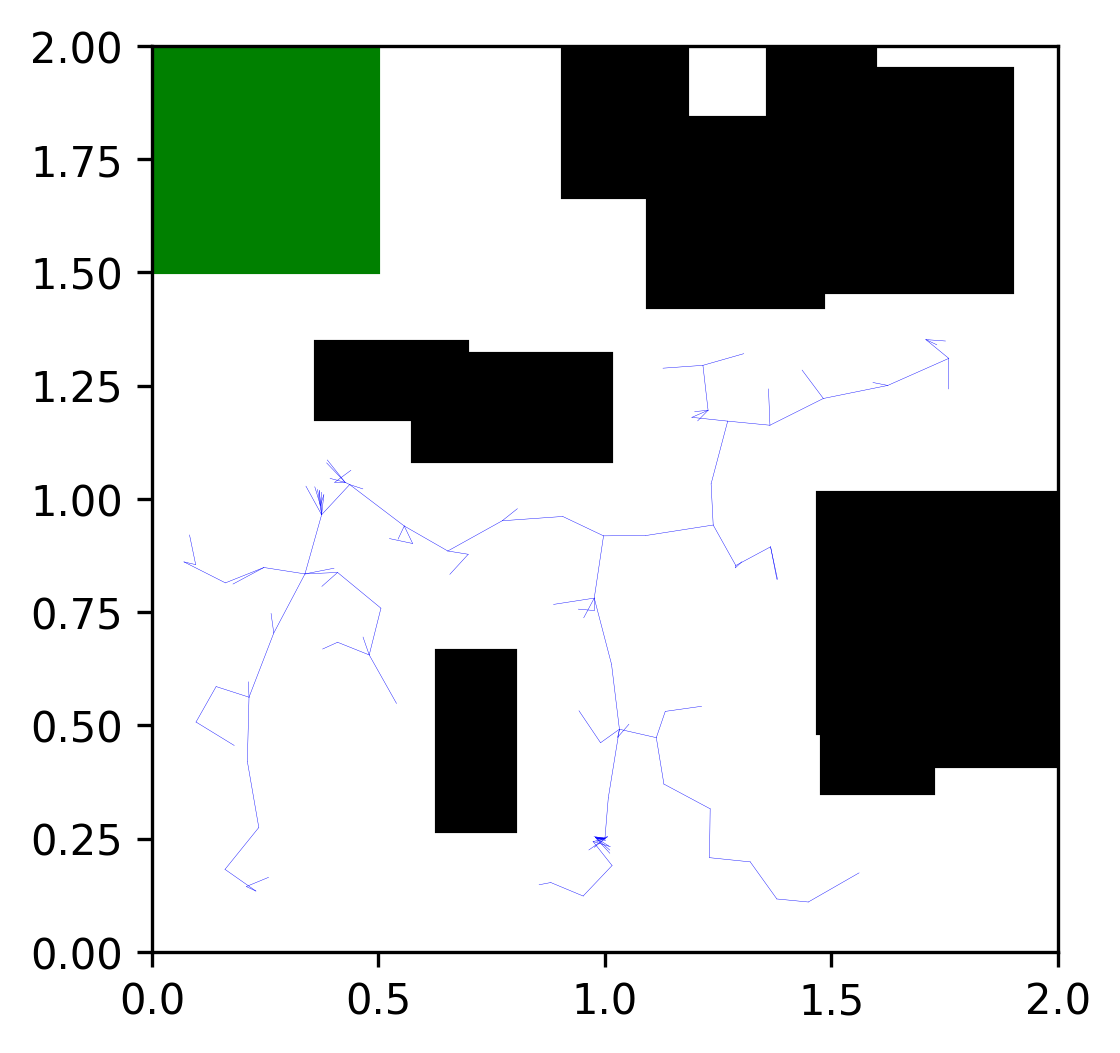

Target Found
[0.21553854316941964, 1.500835343819327, 1.2866703407278777]


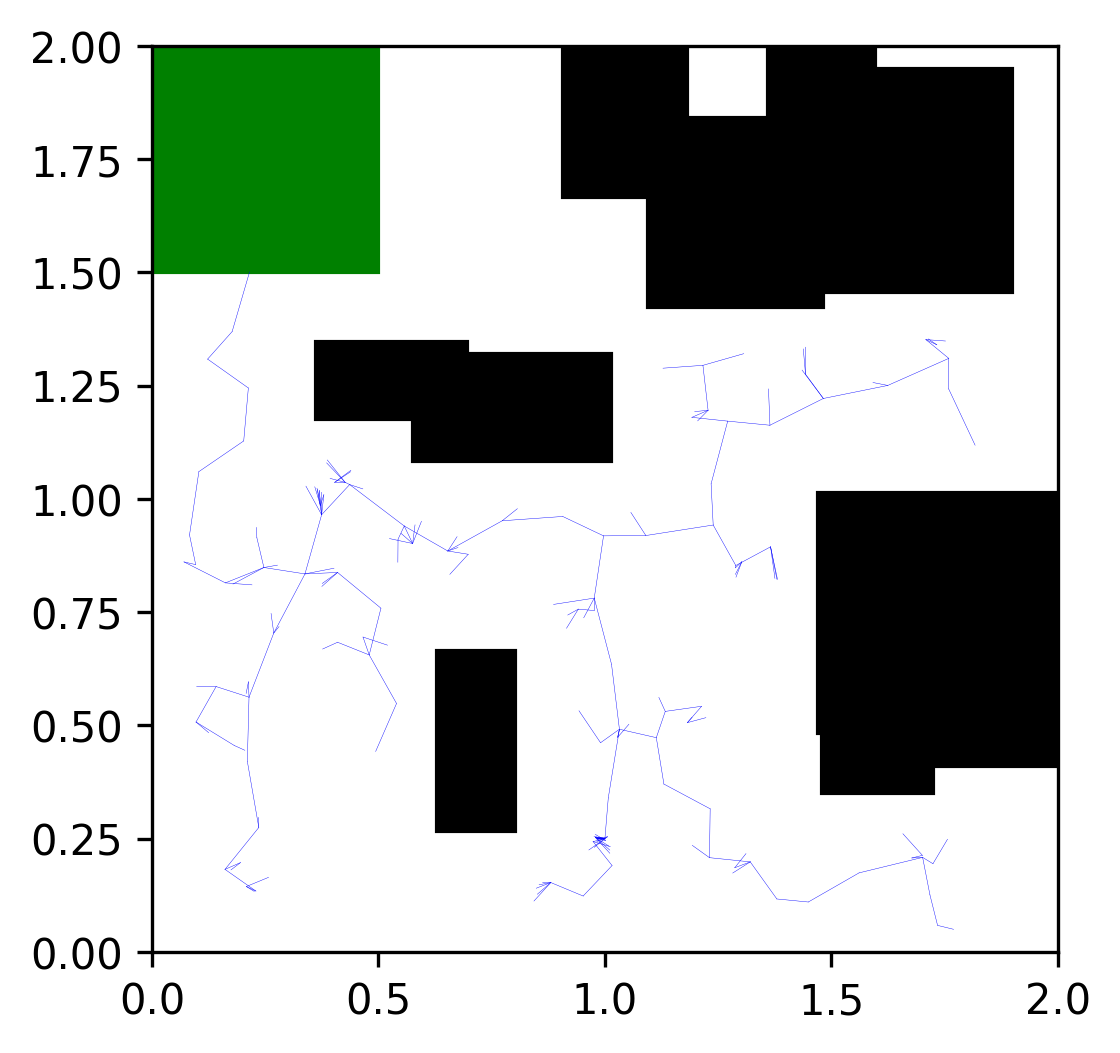

In [27]:
np.random.seed(0)
n_points = 1000
dbg_indx = -1
# ax = show_world(obstacles_list)
xi = [1,0.25,0]
V = [xi]
E = []
C = []
target_found = False
for i in range(n_points):
    xr = [np.random.uniform(0,world_size),np.random.uniform(0,world_size),np.random.uniform(0,2*np.pi)]
    if i==dbg_indx:
        ax = show_world(obstacles_list,target=target)
        for e in E:
            ae = np.array(e)
            plt.plot(ae[:,0],ae[:,1],'b',linewidth =0.1)
        plt.plot(xr[0],xr[1],'rx')
    d_min = 1000
#     print(xr)
    for x in V:
        d = metric(xr,x)
        if d < d_min:
            d_min = d
            x_min = x
    if  i==dbg_indx:
        plt.plot(x_min[0],x_min[1],'bx')
            
#     print("1: ",x_min,xr)
    [traj,controls,x_new] = execute_trajectory(x_min,xr)
    if  i==dbg_indx:
        print("2: ","xr",xr,"s",x_min,"traj",traj,"end",x_new)
#     print("3:" ,x_min,traj)
    if i==dbg_indx:
        plt.plot(x_new[0],x_new[1],'gx')
    collision,d = check_path_for_collisions(x_min,traj,obstacles_list)
    
    if not collision:
        
            
        V.append(x_new)
        E.append([x_min,x_new])
        
        if x_new[0]>target[0][0] and x_new[0]<target[0][0]+target[1][0] and x_new[1]>target[0][1] and x_new[1]<target[0][1]+target[1][1]:
            print("Target Found")
            print(x_new)
            x_final = x_new
            break
#         if x_new[0]>xx1 and x_new[0]<xx3 and x_new[1]>xx2 and x_new[1]<xx4:
#             print("x_min",x_min); print("x_new",x_new); print("traj",traj); print("xr",xr); print("collision", collision)
#             ax = show_world(obstacles_list)      
#             for e in E:
#                 ae = np.array(e)
#                 plt.plot(ae[:,0],ae[:,1],'b',linewidth =0.1)
#             ae = np.array(E[-1])
#             plt.plot(ae[:,0],ae[:,1],'r',linewidth =0.2)
#             break
#         print(x,x_new,traj)
#         ae = np.array([x,x_new])
#         ax = show_world(obstacles_list)
#         plt.plot(ae[:,0],ae[:,1],'b')
#         plt.show()
    if (i%100==0 and i>0) or i==n_points -1:
        plot_rrt_evol(E)
        plt.show()
plot_rrt_evol(E)
plt.show()

In [23]:
def find_parent(e):
    return np.where((Ev[:,1,:]==e).all(axis =1))[0][0]
Ev = np.array(E)
print(Ev.shape)
Ef = Ev[-1,:,:]
print(Ef[0])
print(find_parent(Ef[0]))

def build_tree():
    edge_list = []
    x = Ev[-1,1,:]
    while  np.all(x!=np.array(xi)):
        par_indx = find_parent(x)
        edge_list.insert(0,par_indx)
        x = Ev[par_indx,0]
#         print(edge_list)
    return edge_list
edge_list = build_tree()


(193, 2, 3)
[0.17710362 1.36922098 0.84293565]
189


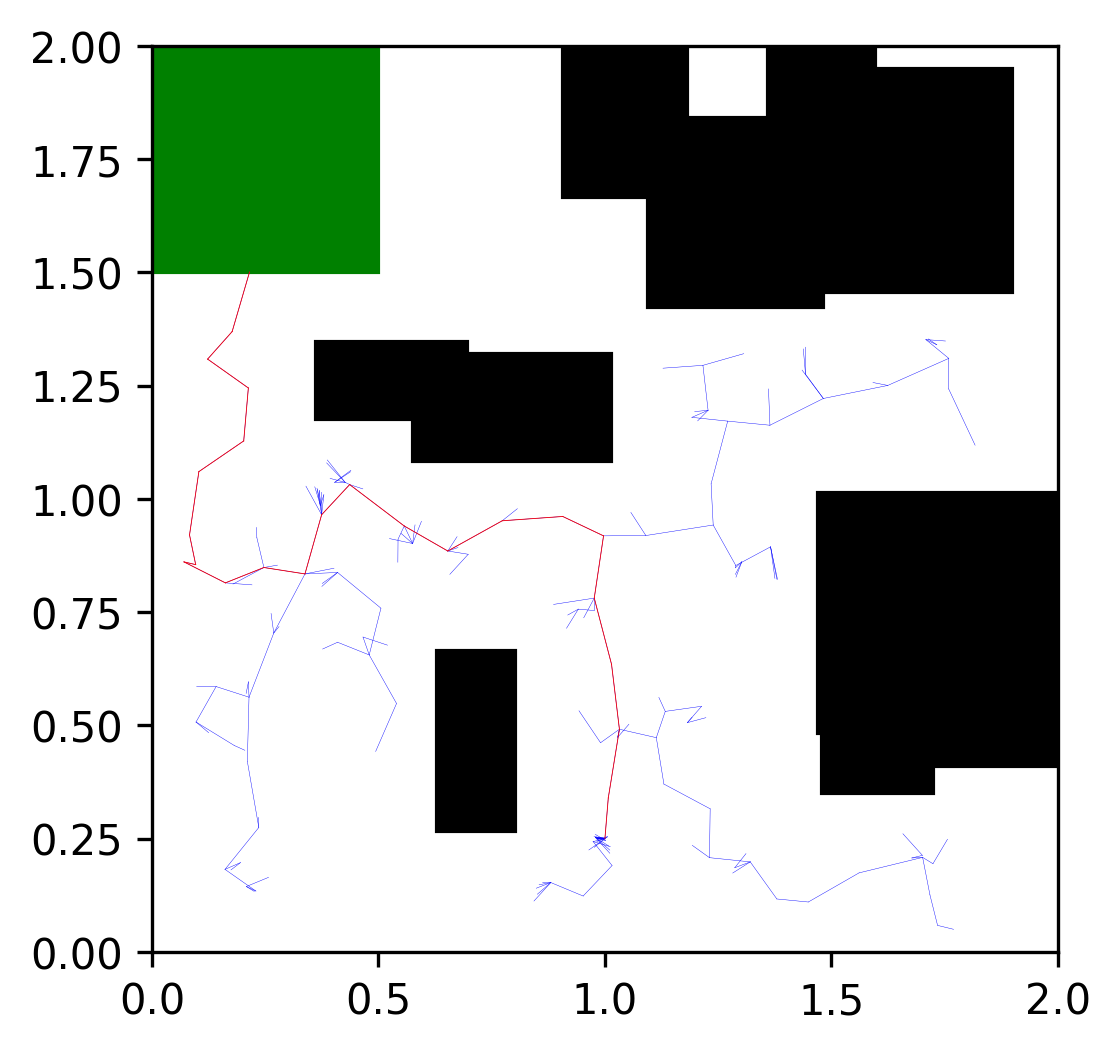

In [24]:
plot_rrt_evol(E)
for indx in edge_list:
    e = E[indx]
    ae = np.array(e)
    plt.plot(ae[:,0],ae[:,1],'r',linewidth =0.2)
plt.show()

In [26]:
for _ in range(100):
    print()